# 1c) Check whether a tweet is harmful to society
- We have a train and test dataset.
- This is an supervised learning task because we have labels that define whether a tweet is harmful or not.

In [50]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import *
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
import random
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter


## Data exploration
- First, lets explore our data:

In [51]:
df_test = pd.read_csv('data/1c/CT22_english_1C_harmful_dev_test.tsv', sep='\t')
df_train = pd.read_csv('data/1c/CT22_english_1C_harmful_train.tsv', sep='\t')
df_valid = pd.read_csv('data/1c/CT22_english_1C_harmful_dev.tsv', sep='\t')

print("Test shape: {}\nTrain shape: {}\nValidation shape: {}".format(df_test.shape, df_train.shape, df_valid.shape))
df_train.head()

Test shape: (910, 5)
Train shape: (3323, 5)
Validation shape: (307, 5)


,topic,tweet_id,tweet_url,tweet_text,class_label
0,COVID-19,1.359351e+18,http://twitter.com/user/status/135935094335617...,"India's gift of 100,000 COVID-19 vaccines arri...",0
1,COVID-19,1.350166e+18,http://twitter.com/user/status/135016568806166...,Here’s what I’m doing while I wait my turn for...,0
2,COVID-19,1.369750e+18,http://twitter.com/user/status/136974953915491...,"This afternoon, I’m hosting an event with the ...",0
3,COVID-19,1.350165e+18,http://twitter.com/user/status/135016499568693...,"Help shops like mine stay open. Mask up, avoid...",0
4,COVID-19,1.370008e+18,http://twitter.com/user/status/137000807648978...,As part of the ongoing nationwide vaccination ...,0


Comment:
- There are 910 tweets in the test data set,
- and 3323 in the train data set.
- The only useful features for our task are the actual tweets and their labels

Checking for inconsistency:

In [52]:
# Train set uniques
print("Unique topics: {}".format(df_train['topic'].unique()))
print("Unique labels: {}".format(df_train['class_label'].unique()))

# Test set uniques
print("Unique topics: {}".format(df_test['topic'].unique()))
print("Unique labels: {}".format(df_test['class_label'].unique()))

# Validation set uniques
print("Unique topics: {}".format(df_valid['topic'].unique()))
print("Unique labels: {}".format(df_valid['class_label'].unique()))

Unique topics: ['COVID-19']
Unique labels: [0 1]
Unique topics: ['COVID-19']
Unique labels: [0 1]
Unique topics: ['COVID-19']
Unique labels: [0 1]


In [53]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910 entries, 0 to 909
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   topic        910 non-null    object
 1   tweet_id     910 non-null    int64 
 2   tweet_url    910 non-null    object
 3   tweet_text   910 non-null    object
 4   class_label  910 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 35.7+ KB


In [54]:
print("Test NA-values: {}\n".format(df_test.isna().sum()))
print("Train NA-values: {}".format(df_train.isna().sum()))
print("Validation NA-values: {}".format(df_valid.isna().sum()))

Test NA-values: topic          0
tweet_id       0
tweet_url      0
tweet_text     0
class_label    0
dtype: int64

Train NA-values: topic          0
tweet_id       0
tweet_url      0
tweet_text     0
class_label    0
dtype: int64
Validation NA-values: topic          0
tweet_id       0
tweet_url      0
tweet_text     0
class_label    0
dtype: int64


Comment: No inconsistencies

<BarContainer object of 2 artists>

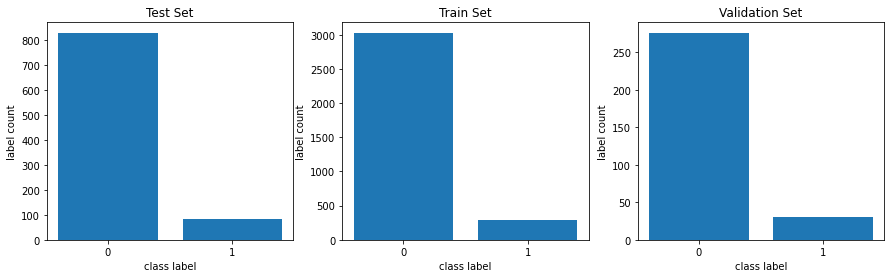

In [55]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(15)

data = df_test['class_label'].value_counts().to_dict()
ax1.set_title('Test Set')
ax1.set_xticks([0, 1])
ax1.set_xlabel("class label")
ax1.set_ylabel("label count")
ax1.bar(data.keys(), data.values())

data = df_train['class_label'].value_counts().to_dict()
ax2.set_title('Train Set')
ax2.set_xticks([0, 1])
ax2.set_xlabel("class label")
ax2.set_ylabel("label count")
ax2.bar(data.keys(), data.values())

data = df_valid['class_label'].value_counts().to_dict()
ax3.set_title('Validation Set')
ax3.set_xticks([0, 1])
ax3.set_xlabel("class label")
ax3.set_ylabel("label count")
ax3.bar(data.keys(), data.values())

In [56]:
print(df_train['class_label'].value_counts())
print(df_test['class_label'].value_counts())
print(df_valid['class_label'].value_counts())

0    3031
1     292
Name: class_label, dtype: int64
0    828
1     82
Name: class_label, dtype: int64
0    276
1     31
Name: class_label, dtype: int64


Comment: 
- We can see that our data is highly imbalanced. 
- Around 91% of our data has are labeled with 0 (harmful tweets) and only around 9% are labeled with 1. 
- We have to keep this in mind when designing our models.

## Preprocessing
- To make our data easier to handle by our ML algorithms we need to preprocess it:
- The function below removes all special characters, URLs, stopwords, lammatizes words and makes them to lowercase.

In [57]:
# Removing stop words from: https://www.geeksforgeeks.org/removing-stop-words-nltk-python/

def preprocess(df):
    processed_text = []
    lemmatizer = WordNetLemmatizer()

    # URL PATTERN copied from: https://stackoverflow.com/questions/520031/whats-the-cleanest-way-to-extract-urls-from-a-string-using-python
    URL_PATTERN = r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:\'\".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))"""
    STOP_WORDS = set(stopwords.words('english'))

    
    for tweet in df['tweet_text']:
        tweet = re.sub(URL_PATTERN, '', tweet)
        tweet = tweet.lower()
        tweet = re.sub('\d', '', tweet) # Remove digits
        tweet = re.sub('[^A-Za-z0-9]+', ' ', tweet) # Remove all special charaters
        tokens = word_tokenize(tweet)
        tweet = [lemmatizer.lemmatize(word) for word in tokens if not word in STOP_WORDS] # Lemmatize and remove stop words
        tweet = " ".join(tweet)
        processed_text.append(tweet)
        
    df['processed_text'] = processed_text 

preprocess(df_train)
preprocess(df_test)
preprocess(df_valid)

A random tweet before and after:

In [58]:
index = random.randint(0, len(df_train['tweet_text'].to_list()))

print("Before:\n" + df_train['tweet_text'].to_list()[index])
print("\nAfter:\n" + df_train['processed_text'].to_list()[index])

Before:
Covenant Health: https://t.co/Z0DQg13k5X Some local pharmacies: https://t.co/j4Nq8msJDM And remember, if you can't get an appointment right away, try again soon. Vaccine distribution is still ramping up. Check your eligibility here: https://t.co/QeDLS1Elfs

After:
covenant health local pharmacy remember get appointment right away try soon vaccine distribution still ramping check eligibility


Most common n words in the train dataset:

In [59]:
def get_most_common_words(n):
    counter = Counter()
    for tweet in df_train['processed_text']:
        for word in tweet.split():
            counter[word] += 1
    return counter.most_common(n)
    
get_most_common_words(9)

[('vaccine', 4107),
 ('covid', 2968),
 ('people', 406),
 ('get', 392),
 ('u', 364),
 ('amp', 340),
 ('health', 324),
 ('coronavirus', 312),
 ('country', 266)]

# Training/Validation
- Since we are dealing with an highly imbalanced data set, we will be using Complement Naive Bayes algorithm to train our model, which is specifically designed imbalanced datasets. (https://scikit-learn.org/stable/modules/naive_bayes.html)
- Because we are dealing with an imbalanced data set we will be using f1 to validate our results.

In [60]:
vectorizer = CountVectorizer(stop_words='english')
vectorizer.fit(df_train['processed_text'])

X_train = vectorizer.transform(df_train['processed_text'])
X_valid = vectorizer.transform(df_valid['processed_text'])
X_test = vectorizer.transform(df_test['processed_text'])

y_train = df_train['class_label'].to_list()
y_valid = df_valid['class_label'].to_list()
y_test = df_test['class_label'].to_list()


The different models:

In [61]:
gnb = GaussianNB()
y_pred_gaussianNB = gnb.fit(X_train.toarray(), y_train).predict(X_valid.toarray())

mnb = MultinomialNB()
y_pred_multinomialNB = mnb.fit(X_train.toarray(), y_train).predict(X_valid.toarray())

cnb = ComplementNB()
y_pred_complementNB = cnb.fit(X_train.toarray(), y_train).predict(X_valid.toarray())

bnb = BernoulliNB()
y_pred_bernoulliNB = bnb.fit(X_train.toarray(), y_train).predict(X_valid.toarray())

lsvc = LinearSVC()
y_pred_lsvc = lsvc.fit(X_train.toarray(), y_train).predict(X_valid.toarray())

In [62]:
print('Gaussian F1-score: {:.2f}, Accuracy: {:.2f}'.format(f1_score(y_valid, y_pred_gaussianNB), accuracy_score(y_valid, y_pred_gaussianNB)))
print('Multinomial F1-score: {:.2f}, Accuracy: {:.2f}'.format(f1_score(y_valid, y_pred_multinomialNB), accuracy_score(y_valid, y_pred_multinomialNB)))
print('Complement F1-score: {:.2f}, Accuracy: {:.2f}'.format(f1_score(y_valid, y_pred_complementNB), accuracy_score(y_valid, y_pred_complementNB)))
print('Bernoulli F1-score: {:.2f}, Accuracy: {:.2f}'.format(f1_score(y_valid, y_pred_bernoulliNB), accuracy_score(y_valid, y_pred_bernoulliNB)))
print('Linear SVC F1-score: {:.2f}, Accuracy: {:.2f}'.format(f1_score(y_valid, y_pred_lsvc), accuracy_score(y_valid, y_pred_lsvc)))

Gaussian F1-score: 0.27, Accuracy: 0.89
Multinomial F1-score: 0.18, Accuracy: 0.91
Complement F1-score: 0.32, Accuracy: 0.90
Bernoulli F1-score: 0.00, Accuracy: 0.90
Linear SVC F1-score: 0.18, Accuracy: 0.88


Comment:
- From the output above we see that the f1-scores aren't the best. This is because the algorithm guesses well on the majority, class but not minority.
- To fix this problem we will try to oversample our minority class.

## Balancing the data
- For the balancing part it makes most sence to oversample the minority class. 
- If we would have undersampled the majority class instead, we would have very few samples to train our models with.

<BarContainer object of 2 artists>

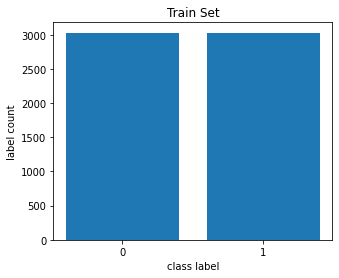

In [63]:
# Inspired by: https://medium.com/analytics-vidhya/undersampling-and-oversampling-an-old-and-a-new-approach-4f984a0e8392

def oversample(df):
    majority_class = max(df.class_label.value_counts())
    df_0 = df[df['class_label'] == 0].sample(majority_class, replace=True)
    df_1 = df[df['class_label'] == 1].sample(majority_class, replace=True)
    return pd.concat([df_0, df_1], axis=0)

def undersample(df):
    minority_class = min(df.class_label.value_counts())
    df_0 = df[df['class_label'] == 0].sample(minority_class, replace=True)
    df_1 = df[df['class_label'] == 1].sample(minority_class, replace=True)
    return pd.concat([df_0, df_1], axis=0)
    
df_train = oversample(df_train)

# Plotting the labels:
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(5)

data = df_train['class_label'].value_counts().to_dict()
ax.set_title('Train Set')
ax.set_xticks([0, 1])
ax.set_xlabel("class label")
ax.set_ylabel("label count")
ax.bar(data.keys(), data.values())

Comment:
- Now we have a balanced train set.
- Let's try test our models again.

In [64]:
vectorizer = CountVectorizer(stop_words='english')
vectorizer.fit(df_train['processed_text'])

X_train = vectorizer.transform(df_train['processed_text'])
X_valid = vectorizer.transform(df_valid['processed_text'])
X_test = vectorizer.transform(df_test['processed_text'])

y_train = df_train['class_label'].to_list()

In [65]:
gnb = GaussianNB()
y_pred_gaussianNB = gnb.fit(X_train.toarray(), y_train).predict(X_valid.toarray())

mnb = MultinomialNB()
y_pred_multinomialNB = mnb.fit(X_train.toarray(), y_train).predict(X_valid.toarray())

cnb = ComplementNB()
y_pred_complementNB = cnb.fit(X_train.toarray(), y_train).predict(X_valid.toarray())

bnb = BernoulliNB()
y_pred_bernoulliNB = bnb.fit(X_train.toarray(), y_train).predict(X_valid.toarray())

lsvc = LinearSVC()
y_pred_lsvc = lsvc.fit(X_train.toarray(), y_train).predict(X_valid.toarray())

In [66]:
print('Gaussian F1-score: {:.2f}, Accuracy: {:.2f}'.format(f1_score(y_valid, y_pred_gaussianNB), accuracy_score(y_valid, y_pred_gaussianNB)))
print('Multinomial F1-score: {:.2f}, Accuracy: {:.2f}'.format(f1_score(y_valid, y_pred_multinomialNB), accuracy_score(y_valid, y_pred_multinomialNB)))
print('Complement F1-score: {:.2f}, Accuracy: {:.2f}'.format(f1_score(y_valid, y_pred_complementNB), accuracy_score(y_valid, y_pred_complementNB)))
print('Bernoulli F1-score: {:.2f}, Accuracy: {:.2f}'.format(f1_score(y_valid, y_pred_bernoulliNB), accuracy_score(y_valid, y_pred_bernoulliNB)))
print('Linear SVC F1-score: {:.2f}, Accuracy: {:.2f}'.format(f1_score(y_valid, y_pred_lsvc), accuracy_score(y_valid, y_pred_lsvc)))

Gaussian F1-score: 0.26, Accuracy: 0.87
Multinomial F1-score: 0.42, Accuracy: 0.85
Complement F1-score: 0.42, Accuracy: 0.85
Bernoulli F1-score: 0.46, Accuracy: 0.86
Linear SVC F1-score: 0.21, Accuracy: 0.86


Comment:
- We get somewhat better F1-scores after oversampling.
- Lets try to find the best parameters for our models

# Hyper-parameter tuning

In [67]:
gnb = GridSearchCV(estimator = GaussianNB(), param_grid = [{'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}], scoring='f1')
y_pred_gaussianNB = gnb.fit(X_train.toarray(), y_train).predict(X_valid.toarray())

mnb = GridSearchCV(estimator = MultinomialNB(), param_grid = [{'alpha': np.arange(1.0e-10, 1, 0.1)}], scoring='f1')
y_pred_multinomialNB = mnb.fit(X_train.toarray(), y_train).predict(X_valid.toarray())

cnb = GridSearchCV(estimator = ComplementNB(), param_grid = [{'alpha': np.arange(1.0e-10, 1, 0.1)}], scoring='f1')
y_pred_complementNB = cnb.fit(X_train.toarray(), y_train).predict(X_valid.toarray())

bnb = GridSearchCV(estimator = BernoulliNB(), param_grid = [{'alpha': np.arange(1.0e-10, 1, 0.1)}], scoring='f1')
y_pred_bernoulliNB = bnb.fit(X_train.toarray(), y_train).predict(X_valid.toarray())

lsvc = GridSearchCV(estimator = LinearSVC(), param_grid = [{'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]}], scoring='f1')
y_pred_lsvc = lsvc.fit(X_train.toarray(), y_train).predict(X_valid.toarray())

In [68]:
print('Gaussian F1-score: {:.2f}, Accuracy: {:.2f}, Best parameter: {}'.format(f1_score(y_valid, y_pred_gaussianNB), accuracy_score(y_valid, y_pred_gaussianNB), gnb.best_params_))
print('Multinomial F1-score: {:.2f}, Accuracy: {:.2f}, Best parameter: {}'.format(f1_score(y_valid, y_pred_multinomialNB), accuracy_score(y_valid, y_pred_multinomialNB), mnb.best_params_))
print('Complement F1-score: {:.2f}, Accuracy: {:.2f}, Best parameter: {}'.format(f1_score(y_valid, y_pred_complementNB), accuracy_score(y_valid, y_pred_complementNB), cnb.best_params_))
print('Bernoulli F1-score: {:.2f}, Accuracy: {:.2f}, Best parameter: {}'.format(f1_score(y_valid, y_pred_bernoulliNB), accuracy_score(y_valid, y_pred_bernoulliNB), bnb.best_params_))
print('Linear SVC F1-score: {:.2f}, Accuracy: {:.2f}, Best parameter: {}'.format(f1_score(y_valid, y_pred_lsvc), accuracy_score(y_valid, y_pred_lsvc), lsvc.best_params_))

Gaussian F1-score: 0.26, Accuracy: 0.87, Best parameter: {'var_smoothing': 1e-09}
Multinomial F1-score: 0.24, Accuracy: 0.88, Best parameter: {'alpha': 1e-10}
Complement F1-score: 0.24, Accuracy: 0.88, Best parameter: {'alpha': 1e-10}
Bernoulli F1-score: 0.24, Accuracy: 0.88, Best parameter: {'alpha': 1e-10}
Linear SVC F1-score: 0.21, Accuracy: 0.86, Best parameter: {'C': 1}


Comment:
- Surprisingly our F1-scores went down after cross validating grid search
- MNB and CNB got the best results, but since the CNB got is a variation of MNB that is used for skewed datasets, we will proceed to use MNB to test our model

# Testing

In [69]:
mnb_final = MultinomialNB(alpha=mnb.best_params_)
y_pred_mnb = mnb.fit(X_train.toarray(), y_train).predict(X_test.toarray())

In [70]:
print("Best parameter: {}".format(mnb.best_params_))
print('Multinomial F1-score: {:.2f}, Accuracy: {:.2f}'.format(f1_score(y_test, y_pred_mnb), accuracy_score(y_test, y_pred_mnb)))

Best parameter: {'alpha': 1e-10}
Multinomial F1-score: 0.28, Accuracy: 0.90
